#  Regularized Polynomial Regression (Order 2) (OLS / Ridge / Lasso / ElasticNet) 

#### Speed specifications & Imports

In [1]:
# Imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from joblib import Parallel, delayed, dump
from threadpoolctl import threadpool_limits

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import TransformerMixin, BaseEstimator

import statsmodels.api as sm
from scipy.stats import f as f_dist 

import warnings; warnings.filterwarnings("ignore")
import re
from math import sqrt

#  SPEED HEADER (single-BLAS + joblib CV) 
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Parallelism knob (for Ryzen 7950X: 16–24; tune to your box)
N_JOBS = 12
RANDOM_STATE = 42

#### Paths, Data Loading & Checks

In [2]:
SAVE_DIR   = 'Data+Files+Plots+etc'
TRAIN_CSV  = f'{SAVE_DIR}/train.csv'
TEST_CSV   = f'{SAVE_DIR}/test.csv'
FOLDS_NPY  = f'{SAVE_DIR}/train_folds.npy' 

# Output paths for residuals
RESID_DIR_OOF = "Data+Files+Plots+etc/Reports"  # OOF Residuals
os.makedirs(RESID_DIR_OOF, exist_ok=True)


def slug(obj):
    """Filename-safe tag for params."""
    if isinstance(obj, dict) and obj:
        parts = []
        for k in sorted(obj.keys()):
            v = obj[k]
            if isinstance(v, (float, np.floating)): v = float(v)
            parts.append(f"{k}={v}")
        s = "__".join(parts)
    else:
        s = str(obj) if obj not in (None, {}, []) else ""
    return re.sub(r"[^A-Za-z0-9._=-]+", "_", s).strip("_")

def base_tag_from_name(name: str) -> str:
    """Map display name to a compact base tag."""
    if "Ridge" in name: return "Ridge"
    if "Lasso" in name: return "Lasso"
    if "ElasticNet" in name: return "ElasticNet"
    if "OLS" in name: return "OLS"
    return slug(name)

#  Load splits
# Preserve original row positions from the CSV (these match train_folds.npy)
df_train = pd.read_csv(TRAIN_CSV)
df_train["_rowpos"] = np.arange(len(df_train), dtype=int)
df_test  = pd.read_csv(TEST_CSV)

# down-sample for speed
#df_train = df_train.sort_values('time').reset_index(drop=True).iloc[::50].reset_index(drop=True)
#df_test  = df_test.sort_values('time').reset_index(drop=True).iloc[::50].reset_index(drop=True)

# Required columns check 
required_cols = [
    'PL','distance','frequency','c_walls','w_walls',
    'co2','humidity','pm25','pressure','temperature','snr'
]
missing = [c for c in required_cols if c not in df_train.columns or c not in df_test.columns]
if missing:
    raise ValueError(f"Missing required columns in train/test: {missing}")

#### Cross-Validation Folds

In [3]:
fold_assignments_full = np.load(FOLDS_NPY)  # vector aligned to ORIGINAL train.csv order

# Remap saved folds to the CURRENT df_train order/selection (works even if sorted/filtered above)
rowpos = df_train["_rowpos"].to_numpy(dtype=int)
if rowpos.max() >= len(fold_assignments_full):
    raise ValueError(
        f"[folds] Mismatch: train_folds.npy len={len(fold_assignments_full)} < max(_rowpos)={rowpos.max()}.\n"
        f"train.csv and train_folds.npy are out of sync."
    )
fold_assignments = fold_assignments_full[rowpos]

# Build (train_idx, val_idx) pairs from the remapped folds
K = int(fold_assignments.max()) + 1
folds = [(np.where(fold_assignments != k)[0], np.where(fold_assignments == k)[0]) for k in range(K)]

print(f"[CV] Using saved folds (remapped) | K={K} | n_train={len(df_train)} | "
      f"fold sizes={[len(v) for _, v in folds]}")

[CV] Using saved folds (remapped) | K=5 | n_train=1663627 | fold sizes=[554543, 277271, 277271, 277271, 277271]


#### Physics, Features & Metrics

In [4]:
# Physics helpers 
d0 = 1.0  # reference distance in meters

def z_of_d(d):
    d = np.clip(d.astype(float), 1e-6, None)
    return 10.0 * np.log10(d / d0)

def f_term(f):
    f = np.clip(f.astype(float), 1e-12, None)
    return 20.0 * np.log10(f)

#  Features & targets 
raw_feats  = ['distance','frequency','c_walls','w_walls',
              'co2','humidity','pm25','pressure','temperature','snr']
target_col = 'PL'

Xtr_raw = df_train[raw_feats].copy()
ytr_pl  = df_train[target_col].astype(float).values
Xte_raw = df_test[raw_feats].copy()
yte_pl  = df_test[target_col].astype(float).values

# Friis adjustment: y_adj = PL - 20*log10(f)
ftr_tr, ftr_te = f_term(Xtr_raw['frequency'].values), f_term(Xte_raw['frequency'].values)
ytr_adj, yte_adj = ytr_pl - ftr_tr, yte_pl - ftr_te

# Base linearized matrix (order matters for the polynomial transformer)
LIN_COLS = ['z_d','c_walls','w_walls','co2','humidity','pm25','pressure','temperature','snr']

Xtr_lin = pd.DataFrame({
    'z_d': z_of_d(Xtr_raw['distance'].values),
    'c_walls': Xtr_raw['c_walls'].values,
    'w_walls': Xtr_raw['w_walls'].values,
    'co2': Xtr_raw['co2'].values,
    'humidity': Xtr_raw['humidity'].values,
    'pm25': Xtr_raw['pm25'].values,
    'pressure': Xtr_raw['pressure'].values,
    'temperature': Xtr_raw['temperature'].values,
    'snr': Xtr_raw['snr'].values
}, columns=LIN_COLS).values

Xte_lin = pd.DataFrame({
    'z_d': z_of_d(Xte_raw['distance'].values),
    'c_walls': Xte_raw['c_walls'].values,
    'w_walls': Xte_raw['w_walls'].values,
    'co2': Xte_raw['co2'].values,
    'humidity': Xte_raw['humidity'].values,
    'pm25': Xte_raw['pm25'].values,
    'pressure': Xte_raw['pressure'].values,
    'temperature': Xte_raw['temperature'].values,
    'snr': Xte_raw['snr'].values
}, columns=LIN_COLS).values

#  Metrics (PL-domain)
def rmse_r2_on_PL(y_true_pl, y_pred_adj, fterm):
    # Convert predictions back to PL-domain using the frequency term of each split
    y_pred_pl = y_pred_adj + fterm
    rmse = sqrt(((y_true_pl - y_pred_pl) ** 2).mean())
    ss_res = ((y_true_pl - y_pred_pl) ** 2).sum()
    ss_tot = ((y_true_pl - y_true_pl.mean()) ** 2).sum()
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return rmse, r2

#### Polynomial Feature Transformer

In [5]:
POLY_KEEP_LINEAR_IDXS = [1, 2]                # keep c_walls, w_walls linear
POLY_EXPAND_IDXS      = [0, 3, 4, 5, 6, 7, 8] # expand z_d + env + snr

class PolyOnContinuous(TransformerMixin, BaseEstimator):
    """
    Degree-2 PolynomialFeatures on selected columns (expand_idxs) and
    concatenate kept linear columns (keep_idxs) in front.
    Produces feature names for reporting.
    """
    def __init__(self, keep_idxs=POLY_KEEP_LINEAR_IDXS, expand_idxs=POLY_EXPAND_IDXS, degree=2, all_names=LIN_COLS):
        self.keep_idxs   = list(keep_idxs)
        self.expand_idxs = list(expand_idxs)
        self.degree      = int(degree)
        self.all_names   = list(all_names)
        self.poly_       = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        in_names = [self.all_names[i] for i in self.expand_idxs]
        self.poly_ = PolynomialFeatures(self.degree, include_bias=False).fit(X[:, self.expand_idxs])
        keep_names = [self.all_names[i] for i in self.keep_idxs]
        poly_names = self.poly_.get_feature_names_out(in_names).tolist()
        # cosmetic: ^2 → ²
        poly_names = [n.replace("^2", "²") for n in poly_names]
        self.feature_names_out_ = keep_names + poly_names
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X_lin  = X[:, self.keep_idxs]
        X_poly = self.poly_.transform(X[:, self.expand_idxs])
        return np.hstack([X_lin, X_poly])

    def get_feature_names_out(self):
        if self.feature_names_out_ is None:
            raise RuntimeError("Call fit() before get_feature_names_out().")
        return np.array(self.feature_names_out_, dtype=object)

# Model Factories and Grids 
def make_PolyOLS(_):
    return make_pipeline(
        PolyOnContinuous(),
        LinearRegression()
    )

def make_PolyRidge(cfg):
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(),
        Ridge(alpha=cfg["alpha"], random_state=RANDOM_STATE)
    )

def make_PolyLasso(cfg):
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(),
        Lasso(alpha=cfg["alpha"], max_iter=20000, random_state=RANDOM_STATE)
    )

def make_PolyENet(cfg):
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(),
        ElasticNet(alpha=cfg["alpha"], l1_ratio=cfg["l1_ratio"], max_iter=20000, random_state=RANDOM_STATE)
    )

ridge_grid = [dict(alpha=a) for a in np.logspace(-4, 3, 15)]
lasso_grid = [dict(alpha=a) for a in np.logspace(-4, 1, 15)]
enet_grid  = [dict(alpha=a, l1_ratio=r) for a in np.logspace(-4, 1, 10) for r in (0.2, 0.5, 0.8)]

poly_specs = [
    ("Poly-OLS (deg2)",        make_PolyOLS,  [dict()]),
    ("Poly-Ridge (deg2)",      make_PolyRidge, ridge_grid),
    ("Poly-Lasso (deg2)",      make_PolyLasso, lasso_grid),
    ("Poly-ElasticNet (deg2)", make_PolyENet,  enet_grid),
]

# Unscale coefficients (poly basis) for reporting
def unscale_poly_coeffs(pipeline):
    """
    Undo StandardScaler in pipeline [PolyOnContinuous, (StandardScaler?), Estimator].
    Returns: intercept, beta vector, feature_names
    """
    steps = pipeline.named_steps
    transformer = steps['polyoncontinuous']
    feat_names = transformer.get_feature_names_out().tolist()
    est = steps.get('ridge') or steps.get('lasso') or steps.get('elasticnet') or steps.get('linearregression')

    if 'standardscaler' not in steps:
        return float(est.intercept_), est.coef_.astype(float).copy(), feat_names

    scaler = steps['standardscaler']
    beta_scaled = est.coef_.astype(float)
    mu, sig = scaler.mean_, scaler.scale_
    beta_orig = beta_scaled / sig
    intercept_orig = float(est.intercept_ - np.sum(beta_scaled * mu / sig))
    return intercept_orig, beta_orig, feat_names

####  CV sweep (folded TRAIN), select best config per variant, refit, and score on TEST (no residual saving)

In [6]:
import time
t0 = time.time()

# K-fold CV over each POLY2 model
poly_results = []
K = int(np.max(fold_assignments)) + 1

# folds from fold_assignments (no helper dependency)
folds = [(np.flatnonzero(fold_assignments != k),
          np.flatnonzero(fold_assignments == k)) for k in range(K)]

print(f"Running CV for {len(poly_specs)} POLY2 variants | K={len(folds)} folds | grid eval={'parallel...' if (N_JOBS != 1) else 'sequential...'}")

def eval_cfg_poly(factory, cfg, folds):
    tr_rmse_list, val_rmse_list, tr_r2_list, val_r2_list = [], [], [], []
    for tr_idx, val_idx in folds:
        X_tr, X_val = Xtr_lin[tr_idx], Xtr_lin[val_idx]
        y_tr, y_val = ytr_adj[tr_idx], ytr_adj[val_idx]
        ypl_tr, ypl_val = ytr_pl[tr_idx], ytr_pl[val_idx]
        f_tr,  f_val    = ftr_tr[tr_idx],  ftr_tr[val_idx]

        pipe = factory(cfg)
        with threadpool_limits(limits=1, user_api="blas"):
            pipe.fit(X_tr, y_tr)

        y_tr_pred_adj = pipe.predict(X_tr)
        rmse_tr, r2_tr = rmse_r2_on_PL(ypl_tr, y_tr_pred_adj, f_tr)
        tr_rmse_list.append(rmse_tr); tr_r2_list.append(r2_tr)

        y_val_pred_adj = pipe.predict(X_val)
        rmse_val, r2_val = rmse_r2_on_PL(ypl_val, y_val_pred_adj, f_val)
        val_rmse_list.append(rmse_val); val_r2_list.append(r2_val)

    return {
        "cfg": cfg,
        "rmse_train_mean": float(np.mean(tr_rmse_list)), "rmse_train_sd": float(np.std(tr_rmse_list)),
        "rmse_val_mean":   float(np.mean(val_rmse_list)), "rmse_val_sd":   float(np.std(val_rmse_list)),
        "r2_train_mean":   float(np.mean(tr_r2_list)),    "r2_train_sd":    float(np.std(tr_r2_list)),
        "r2_val_mean":     float(np.mean(val_r2_list)),   "r2_val_sd":      float(np.std(val_r2_list)),
    }

for name, factory, grid in poly_specs:
    if len(grid) == 1:
        grid_results = [eval_cfg_poly(factory, grid[0], folds)]
    else:
        grid_results = Parallel(n_jobs=N_JOBS, backend="threading", prefer="threads", verbose=0)(
            delayed(eval_cfg_poly)(factory, cfg, folds) for cfg in grid
        )

    best_res = min(grid_results, key=lambda r: r["rmse_val_mean"])
    best_cfg, best_cv = best_res["cfg"], {k: v for k, v in best_res.items() if k != "cfg"}

    # Refit on all training data with best hyperparams
    final_pipe = factory(best_cfg)
    with threadpool_limits(limits=1, user_api="blas"):
        final_pipe.fit(Xtr_lin, ytr_adj)

    # Test (PL domain)
    yte_pred_adj = final_pipe.predict(Xte_lin)
    test_rmse, test_r2 = rmse_r2_on_PL(yte_pl, yte_pred_adj, ftr_te)

    base_tag = base_tag_from_name(name)
    tag_cfg  = slug(best_cfg)
    model_tag = f"POLY2_{base_tag}" if tag_cfg == "" else f"POLY2_{base_tag}__{tag_cfg}"

    # Coefficients in polynomial basis (de-scaled if needed)
    intercept_orig, beta_orig, feat_names = unscale_poly_coeffs(final_pipe)
    coeffs = np.concatenate(([intercept_orig], beta_orig))
    coeff_idx = ["Intercept"] + feat_names
    coeffs_series = pd.Series(coeffs, index=coeff_idx, name=name)

    poly_results.append({
        "model": name,
        "best_cfg": best_cfg,
        "cv": best_cv,
        "test": {"rmse": float(test_rmse), "r2": float(test_r2)},
        "coeffs": coeffs_series,
        "feature_names": feat_names,
        "final_pipe": final_pipe,
        "model_tag": model_tag
    })

t1 = time.time()
print(f"\nProcessing complete in {(t1 - t0)/60:.2f} minutes.")

Running CV for 4 POLY2 variants | K=5 folds | grid eval=parallel...

Processing complete in 1372.85 minutes.


#### CV summary (mean ± sd across folds), best model highlighted, then OOF residuals for BEST are saved.

In [14]:
best_overall = min(poly_results, key=lambda r: r["cv"]["rmse_val_mean"])
best_name    = best_overall["model"]
best_cfg     = best_overall["best_cfg"]
best_tag     = best_overall["model_tag"]

rows = []
for r in poly_results:
    cfg = r.get("best_cfg", {}) if isinstance(r.get("best_cfg", {}), dict) else {"cfg": str(r.get("best_cfg"))}
    rows.append({
        "model":            r["model_tag"].split("__")[0],
        "is_best":          (r["model_tag"] == best_tag),
        "cv_rmse_val_mean": r["cv"]["rmse_val_mean"],
        "cv_rmse_val_sd":   r["cv"]["rmse_val_sd"],
        "cv_r2_val_mean":   r["cv"]["r2_val_mean"],
        "cfg":              slug(cfg),
    })

poly_cv_table = (pd.DataFrame(rows)
                 .sort_values(["cv_rmse_val_mean", "cv_rmse_val_sd", "model"])
                 .reset_index(drop=True))

display(poly_cv_table)

# ---- OOF residuals for BEST (train-only) ----
factory_for_best = next(f for (n, f, g) in poly_specs if n == best_name)

y_pred_adj_oof = np.full(len(ytr_adj), np.nan, dtype=float)
for tr_idx, val_idx in folds:
    pipe = factory_for_best(best_cfg)
    with threadpool_limits(limits=1, user_api="blas"):
        pipe.fit(Xtr_lin[tr_idx], ytr_adj[tr_idx])
    y_pred_adj_oof[val_idx] = pipe.predict(Xtr_lin[val_idx])

mask = ~np.isnan(y_pred_adj_oof)

PL_pred_oof = y_pred_adj_oof[mask] + ftr_tr[mask]
resid_oof   = ytr_pl[mask] - PL_pred_oof

poly_oof_df = pd.DataFrame({
    "model":       "POLY2_BEST",
    "split":       "oof",
    "row_id":      np.arange(len(df_train), dtype=int)[mask],
    "fold":        fold_assignments.astype(int)[mask],
    "time":        df_train.get("time", pd.Series(index=df_train.index, dtype=float)).values[mask],
    "distance":    df_train["distance"].values[mask],
    "frequency":   df_train["frequency"].values[mask],
    "c_walls":     df_train["c_walls"].values[mask],
    "w_walls":     df_train["w_walls"].values[mask],
    "co2":         df_train["co2"].values[mask],
    "humidity":    df_train["humidity"].values[mask],
    "pm25":        df_train["pm25"].values[mask],
    "pressure":    df_train["pressure"].values[mask],
    "temperature": df_train["temperature"].values[mask],
    "snr":         df_train["snr"].values[mask],
    "PL_true":     ytr_pl[mask],
    "PL_pred":     PL_pred_oof,
    "resid_db":    resid_oof
})

oof_path = f"{RESID_DIR_OOF}/residuals__POLY2__BEST__oof.csv"
poly_oof_df.to_csv(oof_path, index=False)
print(f"[OOF] Saved best POLY2 OOF residuals: {oof_path}")

,model,is_best,cv_rmse_val_mean,cv_rmse_val_sd,cv_r2_val_mean,cfg
0,POLY2_Lasso,True,7.376089,0.604844,0.843927,alpha=0.03162277660168379
1,POLY2_ElasticNet,False,7.390878,0.514231,0.843527,alpha=0.0046415888336127815__l1_ratio=0.8
2,POLY2_Ridge,False,7.411379,0.493878,0.842682,alpha=1000.0
3,POLY2_OLS,False,7.467888,0.461938,0.840377,


[OOF] Saved best POLY2 OOF residuals: Data+Files+Plots+etc/Reports/residuals__POLY2__BEST__oof.csv


#### Test metrics table (final fit on full TRAIN, evaluated on held-out TEST).

In [15]:
test_rows = []
for res in poly_results:
    te = res["test"]
    test_rows.append({
        "Model":    res["model_tag"].split("__")[0],
        "Test RMSE": float(te["rmse"]),
        "Test R2":   float(te["r2"]),
    })

test_poly_df = pd.DataFrame(test_rows)
display(test_poly_df)

,Model,Test RMSE,Test R2
0,POLY2_OLS,7.783591,0.829103
1,POLY2_Ridge,7.781888,0.829178
2,POLY2_Lasso,7.770849,0.829662
3,POLY2_ElasticNet,7.777400,0.829375


####  Block ANOVA and Nested Model Analysis

In [16]:
probe = PolyOnContinuous().fit(Xtr_lin)
X_poly_full = probe.transform(Xtr_lin)                 # columns: [walls_linear, poly(expand set)]
poly_names  = probe.get_feature_names_out().tolist()   # 'c_walls','w_walls', then z_d, z_d², co2, co2², ..., z_d co2, ...
W_idx = [0, 1]  # walls kept linear by construction (first 2 columns)
poly_part_names = poly_names[2:]
poly_part_idx   = list(range(2, X_poly_full.shape[1]))
name2col = dict(zip(poly_names, range(len(poly_names))))

def is_interaction(name):
    return (" " in name) or ("*" in name) or (":" in name)

DIST = {'z_d'}
ENV  = {'co2','humidity','pm25','pressure','temperature'}
SNR  = {'snr'}

S_idx, E_idx, N_idx, X_idx = [], [], [], []
for n in poly_part_names:
    j = name2col[n]
    if is_interaction(n):
        X_idx.append(j)
    else:
        base = n.replace('²','').replace('^2','')
        if base in DIST:
            S_idx.append(j)
        elif base in ENV:
            E_idx.append(j)
        elif base in SNR:
            N_idx.append(j)

blocks = {
    "W (walls)": W_idx,
    "S (z_d & z_d²)": S_idx,
    "E (env only)": E_idx,
    "N (snr & snr²)": N_idx,
    "X (all interactions)": X_idx
}
print("Block sizes:", {k: len(v) for k,v in blocks.items()})

def fit_ols_with_const(X, y):
    Xc = sm.add_constant(X, has_constant='add')
    return sm.OLS(y, Xc).fit()

nested_order = ["W (walls)", "S (z_d & z_d²)", "E (env only)", "N (snr & snr²)", "X (all interactions)"]

X_blocks = []
cols_carry = []
for step in nested_order:
    cols_carry += blocks[step]
    X_blocks.append(np.asarray(X_poly_full[:, cols_carry], dtype=float))

yA = ytr_adj.copy()

print("\n Nested block tests (train; degree-2 basis; PL_adj target) ")
df_display = []
prev_res = None
for i, X_now in enumerate(X_blocks):
    res_now = fit_ols_with_const(X_now, yA)
    if i == 0:
        prev_res = res_now
        continue
    RSS_R, RSS_F = np.sum(prev_res.resid**2), np.sum(res_now.resid**2)
    df_R,  df_F  = int(prev_res.df_resid),   int(res_now.df_resid)
    df_num = df_R - df_F
    df_den = df_F
    num = (RSS_R - RSS_F) / max(df_num, 1)
    den = (RSS_F / max(df_den, 1))
    F_stat = num / den if den > 0 else np.nan
    p_val  = 1 - f_dist.cdf(F_stat, df_num, df_den) if np.isfinite(F_stat) else np.nan
    partial_eta2 = (F_stat * df_num) / (F_stat * df_num + df_den) if np.isfinite(F_stat) else np.nan

    add_block = nested_order[i]
    df_display.append({
        "Add block": add_block, "Δdf": df_num,
        "F": F_stat, "p": p_val, "partial η²": partial_eta2
    })
    prev_res = res_now

anova_nested_df = pd.DataFrame(df_display)
display(anova_nested_df)

Block sizes: {'W (walls)': 2, 'S (z_d & z_d²)': 2, 'E (env only)': 10, 'N (snr & snr²)': 2, 'X (all interactions)': 21}

 Nested block tests (train; degree-2 basis; PL_adj target) 


,Add block,Δdf,F,p,partial η²
0,S (z_d & z_d²),2,184140.740420,1.110223e-16,0.181249
1,E (env only),10,1345.526886,1.110223e-16,0.008023
2,N (snr & snr²),2,878961.054795,1.110223e-16,0.513782
3,X (all interactions),21,8958.856005,1.110223e-16,0.101600


#### Drop-One Block ANOVA

In [17]:
full_cols = []
for step in ["W (walls)", "S (z_d & z_d²)", "E (env only)", "N (snr & snr²)", "X (all interactions)"]:
    full_cols += blocks[step]
X_full = X_poly_full[:, full_cols]
res_full = sm.OLS(yA, sm.add_constant(X_full, has_constant='add')).fit()
RSS_full, df_full = np.sum(res_full.resid**2), int(res_full.df_resid)

rows = []
for blk_name, blk_cols in blocks.items():
    keep_cols = [c for c in full_cols if c not in blk_cols]
    X_drop = X_poly_full[:, keep_cols]
    res_drop = sm.OLS(yA, sm.add_constant(X_drop, has_constant='add')).fit()
    RSS_R, df_R = np.sum(res_drop.resid**2), int(res_drop.df_resid)
    df_num = df_R - df_full
    df_den = df_full
    num = (RSS_R - RSS_full) / max(df_num, 1)
    den = (RSS_full / max(df_den, 1))
    F_stat = num / den if den > 0 else np.nan
    p_val  = 1 - f_dist.cdf(F_stat, df_num, df_den) if np.isfinite(F_stat) else np.nan
    partial_eta2 = (F_stat * df_num) / (F_stat * df_num + df_den) if np.isfinite(F_stat) else np.nan
    rows.append({"Dropped block": blk_name, "Δdf": df_num, "F": F_stat, "p": p_val, "partial η²": partial_eta2})

anova_dropone_df = pd.DataFrame(rows).sort_values("p")
print("\n Drop-one partial-F vs Full (degree-2 polynomial basis) ")
display(anova_dropone_df)


 Drop-one partial-F vs Full (degree-2 polynomial basis) 


,Dropped block,Δdf,F,p,partial η²
0,W (walls),2,198617.002194,1.110223e-16,0.192755
1,S (z_d & z_d²),2,21039.244006,1.110223e-16,0.024670
2,E (env only),10,306.815536,1.110223e-16,0.001841
3,N (snr & snr²),2,143519.848603,1.110223e-16,0.147152
4,X (all interactions),21,8958.856005,1.110223e-16,0.101600


#### Top-N Absolute Coefficient Plot 


BEST POLY2 MODEL: Poly-Lasso (deg2) | cfg={'alpha': 0.03162277660168379}
 Coefficients (original units) — full vector 


,coef
Intercept,23.069479
c_walls,6.994472
w_walls,1.146922
z_d,-0.000000
co2,-0.000000
humidity,-0.000000
pm25,0.000000
pressure,0.000000
temperature,-0.071431
snr,-4.316602


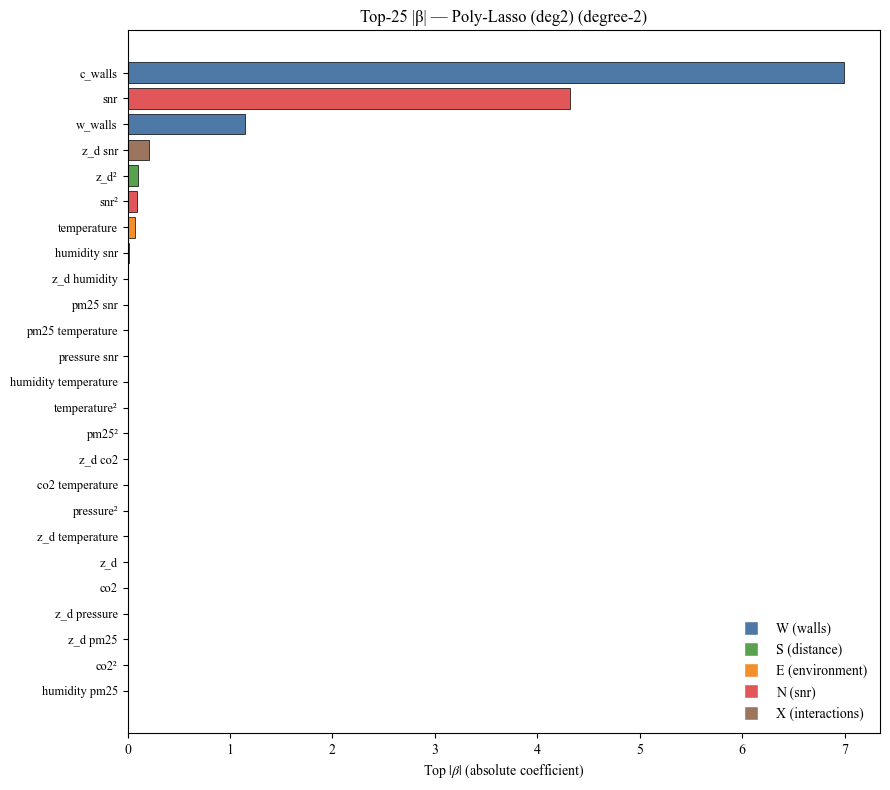

In [18]:
best = min(poly_results, key=lambda r: r['test']['rmse'])
coef_ser = best['coeffs']                  # index: ["Intercept", ..., feature names]; values: coefficients

# PRINT: full coefficients (BEST model) B
print(f"\nBEST POLY2 MODEL: {best['model']} | cfg={best['best_cfg']}")
print(" Coefficients (original units) — full vector ")
display(coef_ser.to_frame('coef').round(6))

names = coef_ser.index.tolist()[1:]        # drop intercept
coefs = coef_ser.values[1:]
feat_names = names

def is_interaction(name):
    return (' ' in name) or ('*' in name) or (':' in name)

def block_of(term):
    if term in ('c_walls','w_walls'):
        return 'W (walls)'
    if is_interaction(term):
        return 'X (interactions)'
    base = term.replace('²','').replace('^2','')
    if base == 'z_d':
        return 'S (distance)'
    if base in {'co2','humidity','pm25','pressure','temperature'}:
        return 'E (environment)'
    if base == 'snr':
        return 'N (snr)'
    return 'X (interactions)'

blocks = [block_of(t) for t in feat_names]
abs_coefs = np.abs(coefs)

TOPN = 25 if len(abs_coefs) >= 25 else len(abs_coefs)
top_idx = np.argsort(-abs_coefs)[:TOPN]
top_names  = [feat_names[i] for i in top_idx]
top_blocks = [blocks[i] for i in top_idx]
top_vals   = abs_coefs[top_idx]

color_map = {
    'W (walls)':        '#4e79a7',
    'S (distance)':     '#59a14f',
    'E (environment)':  '#f28e2b',
    'N (snr)':          '#e15759',
    'X (interactions)': '#9c755f',
}
colors = [color_map[b] for b in top_blocks]

plt.figure(figsize=(9, 8))
ypos = np.arange(TOPN)
plt.barh(ypos, top_vals, color=colors, edgecolor='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.yticks(ypos, top_names, fontsize=9)
plt.xlabel(r'Top $|\beta|$ (absolute coefficient)')
plt.title(f"Top-{TOPN} |β| — {best['model']} (degree-2)")
handles = []
for b, c in color_map.items():
    handles.append(plt.Line2D([0],[0], marker='s', color='w', markerfacecolor=c, markersize=10, label=b))
plt.legend(handles=handles, frameon=False, loc='lower right')
plt.tight_layout()
plt.show()

#### Interaction Coefficient Heatmap

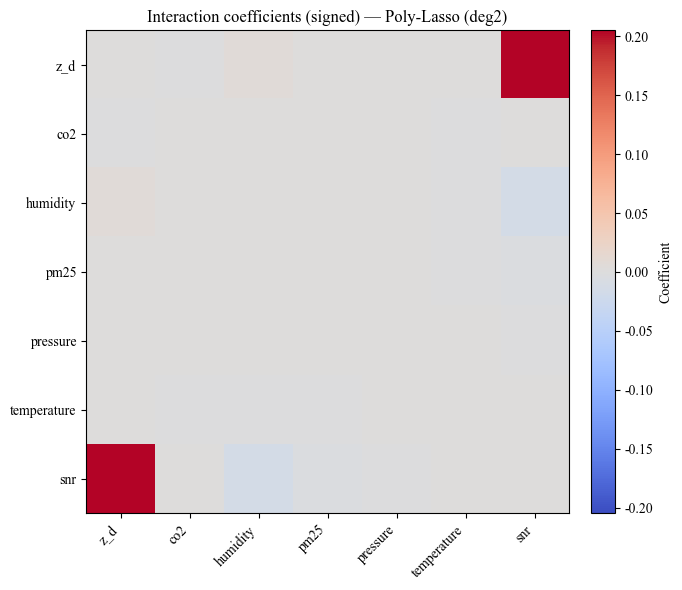

In [19]:
names = coef_ser.index.tolist()[1:]   # drop intercept
coefs = coef_ser.values[1:]

def is_interaction(name):
    return (' ' in name) or ('*' in name) or (':' in name)

base_vars = ['z_d','co2','humidity','pm25','pressure','temperature','snr']
v2i = {v:i for i,v in enumerate(base_vars)}
M = np.zeros((len(base_vars), len(base_vars)))

for name, coef in zip(names, coefs):
    if is_interaction(name):
        parts = name.replace('*',' ').replace(':',' ').split()
        if len(parts) == 2:
            a, b = parts
            a = a.replace('²','').replace('^2','')
            b = b.replace('²','').replace('^2','')
            if a in v2i and b in v2i:
                i, j = v2i[a], v2i[b]
                M[i, j] = coef
                M[j, i] = coef

v = np.max(np.abs(M)) if np.max(np.abs(M)) > 0 else 1.0

plt.figure(figsize=(6.8, 6))
im = plt.imshow(M, cmap='coolwarm', vmin=-v, vmax=v)
plt.xticks(range(len(base_vars)), base_vars, rotation=45, ha='right')
plt.yticks(range(len(base_vars)), base_vars)
plt.title(f"Interaction coefficients (signed) — {best['model']}")
plt.colorbar(im, fraction=0.046, pad=0.04, label='Coefficient')
plt.tight_layout()
plt.show()

#### Block Importance Bar Plot

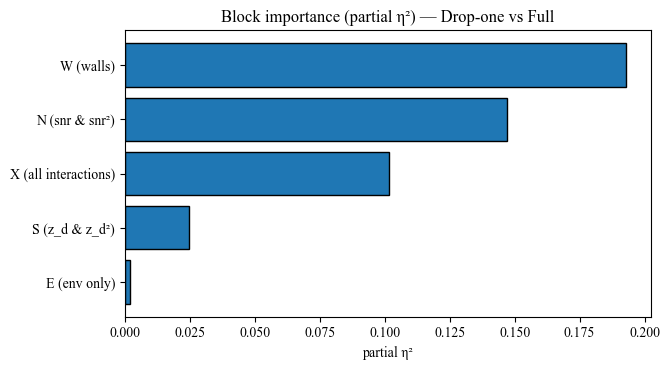

In [20]:
if 'anova_dropone_df' in globals():
    df_plot = anova_dropone_df[['Dropped block','partial η²']].copy()
    df_plot.rename(columns={'Dropped block':'Block'}, inplace=True)
    title = "Block importance (partial η²) — Drop-one vs Full"
elif 'anova_nested_df' in globals():
    df_plot = anova_nested_df[['Add block','partial η²']].copy()
    df_plot.rename(columns={'Add block':'Block'}, inplace=True)
    title = "Block importance (partial η²) — Nested build-up"
else:
    df_plot = None

if df_plot is not None:
    df_plot = df_plot.sort_values('partial η²', ascending=True)
    plt.figure(figsize=(6.8, 3.8))
    plt.barh(df_plot['Block'], df_plot['partial η²'], edgecolor='black')
    plt.xlabel('partial η²')
    plt.title(title)
    plt.tight_layout()
    plt.show()
else:
    print("ANOVA tables not found in memory; run the ANOVA cells first to plot partial η².")